<a href="https://colab.research.google.com/github/thayckowisk/LIA/blob/main/Modelo_02_Vis%C3%A3o_Computacional_Detec%C3%A7%C3%A3o_de_roupas_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color='Blue'>Construindo um Modelo de Identificação de Roupas</font>

O objetivo deste projeto é construir um modelo de Inteligência Artificial capaz de classificar imagens de roupas a partir do dataset Fashion-MNIST (Kaggle). O conjunto de dados contém imagens em escala de cinza (28x28 pixels) de peças de vestuário, distribuídas em 10 categorias:

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Dada uma nova imagem de uma dessas categorias, o modelo deve ser capaz de identificar e indicar corretamente a qual tipo de roupa ela pertence.
 <font color='red'>Usando dataset do Kaggle!</font>



In [29]:
# Versão da Linguagem Python
from platform import python_version
print('Versão do Python neste Notebook:', python_version())

Versão do Python neste Notebook: 3.12.11


In [30]:
# Instala o kaggle
!pip -q install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thayckowisk","key":"3bf088284688fa8e170e06fd68cd0b59"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import pandas as pd


In [6]:
# Baixar o dataset Fashion-MNIST do Kaggle
!kaggle datasets download -d zalando-research/fashionmnist -p /content/data
!unzip -q -o /content/data/fashionmnist.zip -d /content/data/



Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist
License(s): other
  0% 0.00/68.8M [00:00<?, ?B/s]
100% 68.8M/68.8M [00:00<00:00, 1.12GB/s]


\## Carregando os dados


In [7]:
!pip install idx2numpy


  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7903 sha256=7d56479d2bb1458194387d3d754464c5acf1d394f63773d5e478cce904356749
  Stored in directory: /root/.cache/pip/wheels/f7/48/00/ae031c97d62f39e1c3c4daa00426c09a65eb29ae5753a189ee
Successfully built idx2numpy


In [8]:
import idx2numpy

# Definição dos caminhos dos arquivos contendo os dados no formato IDX
train_images_path = '/content/data/train-images-idx3-ubyte'
train_labels_path = '/content/data/train-labels-idx1-ubyte'
test_images_path = '/content/data/t10k-images-idx3-ubyte'
test_labels_path = '/content/data/t10k-labels-idx1-ubyte'

# Carregamento dos dados de treino e teste (imagens e rótulos)
# A biblioteca idx2numpy converte os arquivos IDX (formato usado no MNIST) em arrays NumPy
imagens_treino = idx2numpy.convert_from_file(train_images_path)
labels_treino = idx2numpy.convert_from_file(train_labels_path)
imagens_teste = idx2numpy.convert_from_file(test_images_path)
labels_teste = idx2numpy.convert_from_file(test_labels_path)

imagens_treino = imagens_treino / 255.0
imagens_teste = imagens_teste / 255.0



In [9]:
nomes_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Pré-processamento e Visualização das imagens

In [10]:
# Fashion-MNIST tem shape (28, 28), adiciona canal (1) para ser aceito pela CNN
imagens_treino = imagens_treino.reshape((-1, 28, 28, 1)) / 255.0
imagens_teste = imagens_teste.reshape((-1, 28, 28, 1)) / 255.0

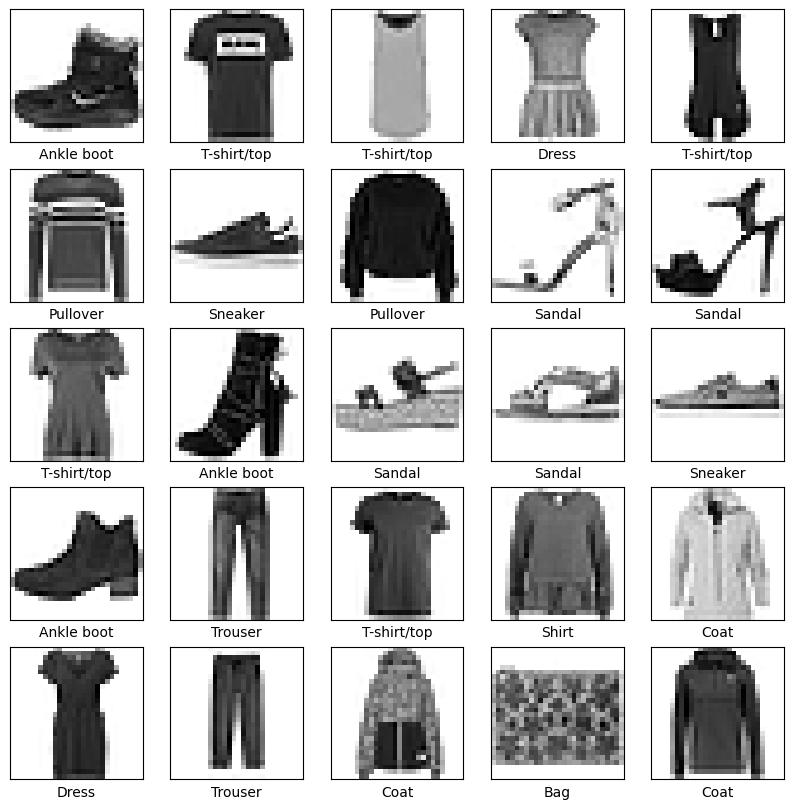

In [11]:
# Função para exibir as imagens
def visualiza_imagens(images, labels):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].squeeze(), cmap=plt.cm.binary)
        plt.xlabel(nomes_classes[labels[i]])
    plt.show()

#Executa a função
visualiza_imagens(imagens_treino, labels_treino)


## Construção do Modelo

In [14]:
from tensorflow.keras import models, layers, callbacks

# Modelo CNN melhorado
modelo = models.Sequential([
    # Entrada
    layers.Input(shape=(28,28,1)),

    # Bloco 1
    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    # Bloco 2
    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    # Bloco 3
    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    # Classificação
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
])

# Compilar modelo
modelo.compile(optimizer="adam",
               loss="sparse_categorical_crossentropy",
               metrics=["accuracy"])

# Callbacks para melhorar treino - função earlystopping percebe que a acurácia de validação (val_accuracy)
# não melhora por 3 épocas seguidas, ele diminui a taxa de aprendizado (learning rate) pela metade (factor=0.5)
# ajuda a eele continuar aprendendo de forma mais lentta e estável refinando os pesos.
cbs = [
    callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, verbose=1),
    callbacks.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True, verbose=1)
# Se mesmo com ReduceLROnPlateau a validação não melhorar por 8 épocas seguidas, o treino é interrompido
]

# Treinamento
historico = modelo.fit(
    imagens_treino, labels_treino,
    epochs=35,
    batch_size=128,
    validation_data=(imagens_teste, labels_teste),
    callbacks=cbs
)

# Resumo do modelo
modelo.summary()



Epoch 1/35
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - accuracy: 0.6790 - loss: 0.9713 - val_accuracy: 0.2555 - val_loss: 2.5501 - learning_rate: 0.0010
Epoch 2/35
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8547 - loss: 0.4064 - val_accuracy: 0.8535 - val_loss: 0.3779 - learning_rate: 0.0010
Epoch 3/35
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8775 - loss: 0.3386 - val_accuracy: 0.8965 - val_loss: 0.2956 - learning_rate: 0.0010
Epoch 4/35
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8915 - loss: 0.3002 - val_accuracy: 0.9023 - val_loss: 0.2667 - learning_rate: 0.0010
Epoch 5/35
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9018 - loss: 0.2768 - val_accuracy: 0.9085 - val_loss: 0.2527 - learning_rate: 0.0010
Epoch 6/35
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9060 - loss: 0.2644 - val_accuracy: 0.8953 - val_loss: 0.2795 - learning_rate: 0.0010
Epoch 7/35
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9135 - loss: 0

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 866,752 (3.31 MB)

 Trainable params: 288,618 (1.10 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 577,238 (2.20 MB)

## Avaliação do modelo

In [15]:
# Avalia o modelo
erro_teste, acc_teste = modelo.evaluate(imagens_teste, labels_teste, verbose=2)
print("Acurácia com dados de teste:", acc_teste)


313/313 - 3s - 9ms/step - accuracy: 0.9386 - loss: 0.1879
Acurácia com dados de teste: 0.9386000037193298


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


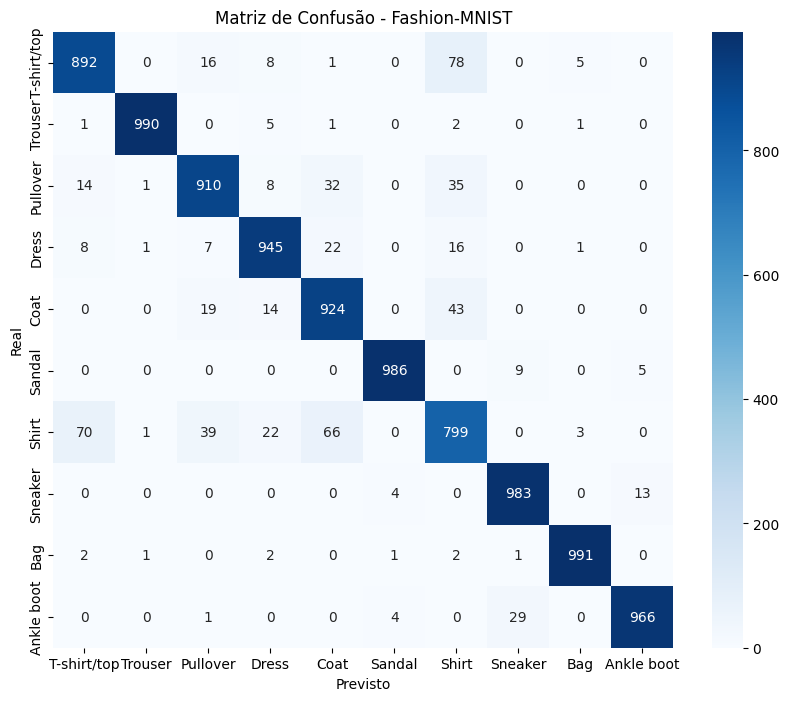

In [16]:
# Imprime a matriz de confusão
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predições
y_pred = modelo.predict(imagens_teste)
y_pred_classes = np.argmax(y_pred, axis=1)

# Labels verdadeiros
y_true = labels_teste

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=nomes_classes,
            yticklabels=nomes_classes)
plt.title('Matriz de Confusão - Fashion-MNIST')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()


## Deploy do modelo

Shape final da imagem: (1, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
A nova imagem foi classificada como: Pullover com 99.89% de confiança


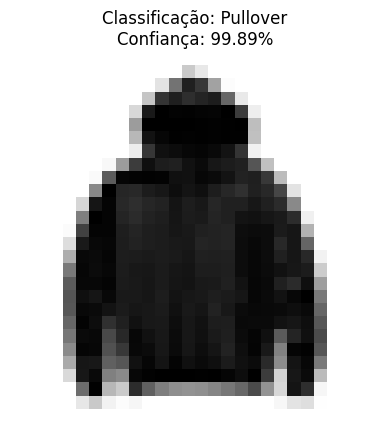

In [32]:
## Deploy do modelo

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Carrega e prepara a nova imagem
nova_imagem = Image.open("/content/imagef3.jpg").convert("L")   # grayscale
nova_imagem = nova_imagem.resize((28, 28))            # redimensiona

# Converter para array NumPy e normalizar
nova_imagem_array = np.array(nova_imagem) / 255.0

# Ajustar dimensões: (28,28) → (28,28,1) → (1,28,28,1)
nova_imagem_array = np.expand_dims(nova_imagem_array, axis=-1)
nova_imagem_array = np.expand_dims(nova_imagem_array, axis=0)

print("Shape final da imagem:", nova_imagem_array.shape)

# Fazer previsão
previsoes = modelo.predict(nova_imagem_array)

# Classe prevista e confiança
classe_prevista = np.argmax(previsoes)
confianca = previsoes[0][classe_prevista]  # probabilidade da classe escolhida
nome_classe_prevista = nomes_classes[classe_prevista]

print(f"A nova imagem foi classificada como: {nome_classe_prevista} "
      f"com {confianca:.2%} de confiança")

# Exibir a imagem usada
plt.imshow(nova_imagem, cmap="gray")
plt.title(f"Classificação: {nome_classe_prevista}\nConfiança: {confianca:.2%}")
plt.axis("off")
plt.show()


In [35]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Função para capturar foto da webcam no Colab
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const video = document.createElement('video');
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Espera clique para capturar
      await new Promise((resolve) => { video.onclick = resolve; });

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(track => track.stop());
      div.remove();

      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Tira a foto
filename = take_photo()
print("Foto capturada:", filename)

# Mostra a foto
nova_imagem = Image.open(filename).convert("L").resize((28,28))
plt.imshow(nova_imagem, cmap="gray")
plt.axis("off")
plt.show()


<IPython.core.display.Javascript object>

KeyboardInterrupt: 

Se você chegou até aqui, parabéns! 🎆 🔥